In [31]:
import numpy as np, matplotlib, pyfits as fits, shutil, os
import healpy as hp
from matplotlib.colors import LogNorm
%matplotlib inline
from functools import partial
from time import time
from tqdm import trange

from Convenience import *


Here we produce the likelihood function for a dwarf host galaxy like IC10, using model given by Heesen et al. 2011.
For this, V. Heesen provided his C-code that computes the LoS integrals.
We compute these integrals for different orientation of the galaxy and combine the results in the resulting likelihood function.
We repeat this procedure with different magnetic field strengths $B$ and add the results according to some prior distribution of $B$.

first, define some functions to handle the C-code, its parameters and output.

In [39]:
root = '/data/physics/FRB/IC10/Polsims/'
folder_PolSim = '/data/physics/FRB/IC10/Polsim2'

filename = root+'RMs.fits' 

def ReadMs( filename ):
    return fits.open( filename )[0].data[0,0]

def GetMs( folder, M_min=1e-3, plot=False, absolute=True, measure='RM' ):
    Ms = ReadMs( root+folder+'/'+measure+'s.fits' )
    if plot:
        plt.imshow( Ms )#  , norm=LogNorm() if absolute else None )
        plt.colorbar()
        
    Ms_abs = np.abs( Ms )
    if absolute:
        Ms = Ms_abs
    return Ms[ np.where( Ms_abs > M_min) ]    
#    return RMs[ np.where( RMs_abs/RMs_abs.max() > RM_min) ]    




In [3]:
from tempfile import mkstemp
from shutil import move
from os import fdopen, remove

def ReplaceLine(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with fdopen(fh,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)
    
def ReplaceTheta( folder, theta ):
    # theta in degree
    ReplaceLine( root+folder+'/main.c', '    ia = 0.0;', '    ia = %.1f;' % theta )

def ReplaceB( folder, B ):
    ## B in muG
    ReplaceLine( root+folder+'/main.c', '   E_d0 = 0.5;', '   E_d0 = %.1f;' % B )

def Replacen( folder, n ):
    ## n in cm^-3
    ReplaceLine( root+folder+'/main.c', '    ne_0 = 0.1;', '    ne_0 = %f;' % n )
    
    

In [24]:
## compiles and calls the C-code with the desired parameters
def PolSim( theta, force=False, RM_min=1e-3, B=0.5, n=0.1, plot=False, delete=True, get_DM=True, DM_min=1e-3 ):
    folder = 'theta%.0f_n%.3f_B%.2f' % ( theta, n, B )
    ## copy ProSim folder
    if force:
        try:
            os.system( "rm -rf %s/%s" % ( root, folder ) )
        except:
            pass
    if os.path.isfile(root+folder+"RMs.fits"):
        print 'theta %.0f exists' % theta
        return GetMs( folder, M_min=RM_min, plot=plot, measure='RM' ), GetMs( folder, M_min=RM_min, plot=plot, measure='DM' )
    else:
        shutil.copytree( folder_PolSim, root+folder )    
    '''
#    try:
    if True:
        print root+folder
        shutil.copytree( folder_PolSim, root+folder )    
#    except:
        print 'theta %.0f exists' % theta
#        return GetMs( folder, M_min=RM_min, plot=plot, measure='RM' )
        return GetMs( folder, M_min=RM_min, plot=plot, measure='RM' ), GetMs( folder, M_min=RM_min, plot=plot, measure='DM' )
    '''
    ## modify parameters
    ReplaceTheta( folder, theta )    
    ReplaceB( folder, B )    
    Replacen( folder, n )    
    ## compile and execute
    os.system( "cd %s && ./compile.sh && ./pol.x" % (root+folder) )
    ## read & return values of fits file
    res = GetMs( folder, plot=plot, M_min=RM_min, measure='RM' )[:]
    res1 = GetMs( folder, plot=plot, M_min=DM_min, measure='DM' )[:]
    if delete:
        os.system( "rm -rf %s/%s" % ( root, folder ) )
#    return res
    return res, res1

choose directions and penetration depths of LoS

In [7]:
l0 = 0.5
l1 = 0
l2 = 1
h = 0.15
N_ = 1. / ( 2 * h * ( 1 - np.exp( -(l0-l1)/h ) ) )
#N_ = 3.45664568863346

def inverse_CDF_depth( u, a=1., b=1., c=1., N=1. ):
    return np.log( (a*N-u)/b/N )

def inverse_CDF_depth( u, sgn=1, b=np.exp((l1-l0)/h) ):
    return sgn*h*np.log( u/N_/h + b ) + l0 

def Sample_depth( N ):
    u = np.random.uniform( size=N )
    depths = inverse_CDF_depth( u )
    u_hi = u > l0
    depths[u_hi] = inverse_CDF_depth( 0.5-u[u_hi], sgn=-1, b=1 )
    return depths

Text(0,0.5,'y')

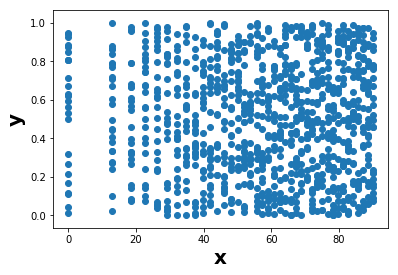

In [29]:
N_depths, N_theta = 25, 40

#depths = np.linspace( 0.05, 0.95, N_depths )           ## fixed equidistant depths
#depths = np.random.rand( N_depths )              ## fixed random depths
depths = np.random.rand( N_theta, N_depths )     ## random depths
      ## random depths following scale height
#depths = Sample_depth( N_theta*N_depths ).reshape( N_theta, N_depths )

thetas = np.arccos( np.linspace( 0, 1, N_theta ) ) * 180./np.pi              ## fixed evenly distributed thetas
#thetas = np.arccos( np.random.rand( N_theta )*2 - 1 ) * 180./np.pi            ## fixed random thetas
#thetas = np.arccos( np.random.rand( N_theta, N_depths )*2 - 1 ) * 180./np.pi  ## random thetas

th = np.array( [thetas]*N_depths ).transpose()
ds = np.array( [depths]*N_theta )
ds = depths.flatten()
plt.scatter( th, ds )
#plt.scatter( thetas.flatten(), depths.flatten() )
#ScatterDensityPlot( thetas.flatten(), depths.flatten() )
plt.xlabel('x', fontdict={'size':20, 'weight':'bold'} )
plt.ylabel('y', fontdict={'size':20, 'weight':'bold'} )


In [9]:
np.random.uniform?

In [10]:
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
def ScatterDensityPlot( x, y, weight=1., log=False, xlim=None, ylim=None ):
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)*weight

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    cax = ax.scatter(x, y, c=z, s=50, edgecolor='', norm=LogNorm() if log else None)
    if xlim:
        ax.set_xlim(*xlim)
    if ylim:
        ax.set_ylim(*ylim)
    cb = fig.colorbar( cax )
    cb.set_label(label='RM',weight='bold', size=20)

In [ ]:
from multiprocessing import Pool


def PolSim_RM( i, B=0.5, n=0.1, thetas=thetas, depths=depths, RM_min=1e-3 ):
    th, ds = thetas[i], depths[i]    
    RM = PolSim( th, force=True, B=B, n=n, delete=True, RM_min=RM_min, get_DM=False )
    RM = np.abs(RM)
    return np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] )

def PolSim_RMDM( i, B=0.5, n=0.1, thetas=thetas, depths=depths, RM_min=1e-3, get_DM=True, DM_min=1e-3 ):
#    th, ds = thetas[i], depths[i]    
    th, ds = thetas[i], depths
    RM, DM = PolSim( th, force=True, B=B, n=n, delete=True, RM_min=RM_min, get_DM=True, DM_min=DM_min )
    RM = np.abs(RM)
    return np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] ), np.reshape( DM, [len(DM),1] ) * np.reshape( ds, [1,N_depths] )

    

def Likelihood_RM( B=0.5, n=0.1, RM_min=1e-3, thetas=thetas, depths=depths, plot_map=False ):
    pool = Pool(4)
    PS = partial( PolSim_RM, n=n, B=B )
    RM_lists = pool.map( PS , range(len(thetas))[::7] )
#    RM_lists = map( PS , range(len(thetas))[::7] )
    RMs = []
    for l in RM_lists:
        RMs.extend(l)

    '''
    for th, ds in zip( thetas, depths ):
        RM = PolSim( th, force=True, B=B, n=n, delete=True, RM_min=RM_min, plot=plot_map )
        RM = np.abs(RM)
        RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] ) )
        if plot_map:
            plt.title( r"$\theta$ = %.0f" % th )
            plt.show()
    '''
    return histogram( np.array( RMs ).flatten(), density=True, log=True, bins=100 )

def Likelihood_RMDM( B=0.5, n=0.1, RM_min=1e-3, DM_min=1e-3, thetas=thetas, depths=depths, plot_map=False ):
    pool = Pool(4)
    PS = partial( PolSim_RMDM, n=n, B=B, RM_min=RM_min, DM_min=DM_min, get_DM=True, depths=depths )
    M_lists = pool.map( PS , range(len(thetas))[::7] )
#    M_lists = map( PS , range(len(thetas))[::7] )
    RMs, DMs = [], []
    for l in M_lists:
        RMs.extend(l[0])
        DMs.extend(l[1])

    '''
    for th, ds in zip( thetas, depths ):
        RM = PolSim( th, force=True, B=B, n=n, delete=True, RM_min=RM_min, plot=plot_map )
        RM = np.abs(RM)
        RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] ) )
        if plot_map:
            plt.title( r"$\theta$ = %.0f" % th )
            plt.show()
    '''
    return histogram( np.array( RMs ).flatten(), density=True, log=True, bins=100 ), histogram( np.array( DMs ).flatten(), density=True, log=True, bins=100 )



In [26]:
'''
RM_range = ( 1e-10, 1e3 )
RMs = []
#for th in thetas[::3]:
for th, ds in zip( thetas, depths )[::3]:
#    RM = GetRM( th )
    RM = PolSim( th, force=True, delete=False, plot=True )
    RM = np.abs(RM)
#    RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( depths, [1,N_depths] ) )
    RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] ) )
    plt.title( r"$\theta$ = %.0f" % th )
    plt.show()
RMs = np.array( RMs )
P, x = histogram( RMs.flatten(), density=True, log=True, bins=100 )
'''
P, x = Likelihood_RM( )
PlotLikelihood( x, P, log=True, measure='RM' )
plt.show()

ValueError: cannot reshape array of size 13872 into shape (2,1)

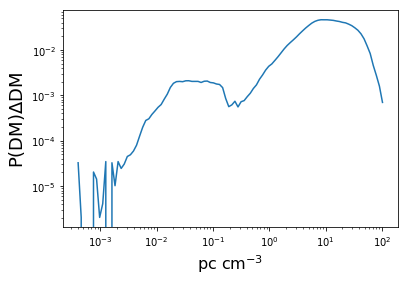

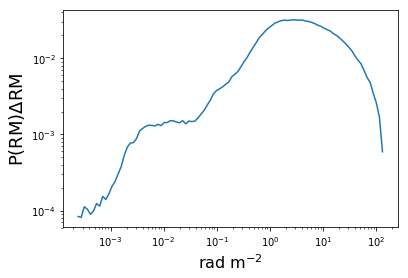

Process PoolWorker-159:
Process PoolWorker-157:
Process PoolWorker-160:
Process PoolWorker-158:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)


In [48]:
### uniform FRB distribution
depths = np.random.rand( N_depths )     ## random depths

(P, x), (P1, x1) = Likelihood_RMDM( DM_min=1e-1, RM_min=1e-1, depths=depths)
PlotLikelihood( x1, P1, log=True, measure='DM' )
plt.show()
PlotLikelihood( x, P, log=True, measure='RM' )
plt.show()


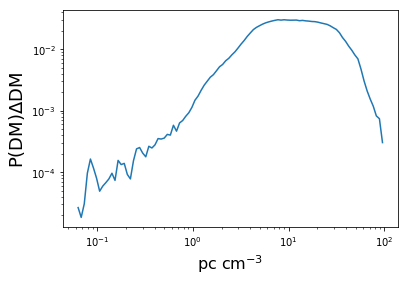

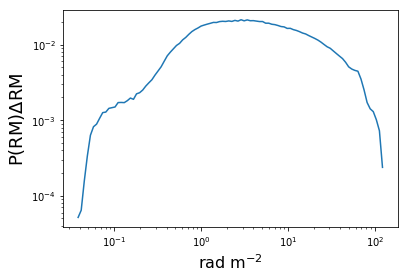

Process PoolWorker-163:
Process PoolWorker-162:
Process PoolWorker-161:
Process PoolWorker-164:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run


In [49]:
### centered FRB distribution
depths = Sample_depth( N_depths )

(P, x), (P1, x1) = Likelihood_RMDM( DM_min=1e-1, RM_min=1e-1, depths=depths)
PlotLikelihood( x1, P1, log=True, measure='DM' )
plt.show()
PlotLikelihood( x, P, log=True, measure='RM' )
plt.show()


To account for different ISM densities in the host dwarf galaxy, we make use of the fact that, both, $DM \& RM \propto n_{\rm ISM}$, which is illustrated below.
This allows fast computation for other values of $n_{\rm ISM}$.

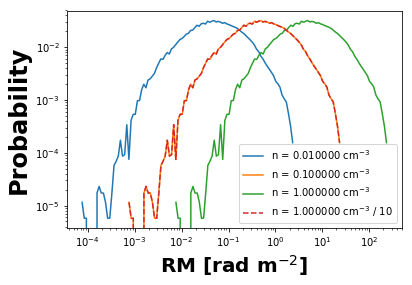

In [50]:
RM_range = ( 1e-10, 1e3 )
#for th in thetas[::3]:

fig, ax = plt.subplots()

for n in [0.01,0.1,1]:

    #'''
    RMs = []
    for th, ds in zip( thetas, depths )[4:5:3]:
#    RM = GetRM( th )
        RM = PolSim( th, force=True, n=n )
        RM = np.abs(RM)
#    RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( depths, [1,N_depths] ) )
        RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] ) )
#    plt.title( r"$\theta$ = %.0f" % th )
#    plt.show()
    RMs = np.array( RMs )
    P, x = histogram( RMs.flatten(), density=True, log=True, bins=100 )
    '''
    P, x = Likelihood_RM( n=n )
    '''
    PlotLikelihood( x, P, log=True, measure='RM', label="n = %f cm$^{-3}$" % n, ax=ax )
PlotLikelihood( x/10, P*10, log=True, measure='RM', label="n = %f cm$^{-3}$ / 10" % n, ax=ax, linestyle='--' )
plt.legend()
plt.show()

However, as shown below, this is not the case for the strength of the ordered magnetic field $B_{\rm Host}$, which has a more complicated influence on $P(RM_{\rm Host}|Heesen11)$.
This requires us to perform several sets of simulations with different choices of $B$.

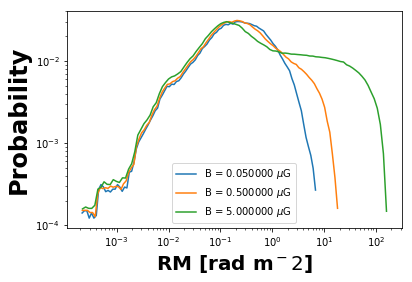

In [38]:
RM_range = ( 1e-10, 1e3 )

fig, ax = plt.subplots()

B=0.5
for B in [0.05,0.5,5]:
    #'''
    RMs = []
    for th, ds in zip( thetas, depths )[:3]:
#    RM = GetRM( th )
        RM = PolSim( th, force=True, B=B, delete=False, RM_min=1e-2 )
        RM = np.abs(RM)
#    RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( depths, [1,N_depths] ) )
        RMs.extend( np.reshape( RM, [len(RM),1] ) * np.reshape( ds, [1,N_depths] ) )
#    plt.title( r"$\theta$ = %.0f" % th )
#    plt.show()
    RMs = np.array( RMs )
    P, x = histogram( RMs.flatten(), density=True, log=True, bins=100 )
    '''
    P, x = Likelihood_RM( B=B )
    '''
    PlotLikelihood( x, P, log=True, measure='RM', ax=ax, label=r"B = %f $\mu$G" % B )
#PlotLikelihood( x/10, P*10, log=True, measure='RM', ax=ax, label=r"B = %f $\mu$G / 10" % B, linestyle='--' )
plt.legend()
plt.show()

Here we prepare reasonable priors for $n_{\rm ISM}$ and $B_{\rm Host}$.

In [52]:
## number density of ISM n_ISM,  use Allivez 2005, Fig. 7
n_lo = 5e-3
n_hi = 3e0
Sample_n = lambda N: uniform_log( n_lo, n_hi, N )

## magnetic field of host dwarf galaxy B_Host,  use Chyzy 2016, Tab. 3
B_lo = 5e-1
B_hi = 5e0
Sample_B = lambda N: uniform_log( B_lo, B_hi, N )


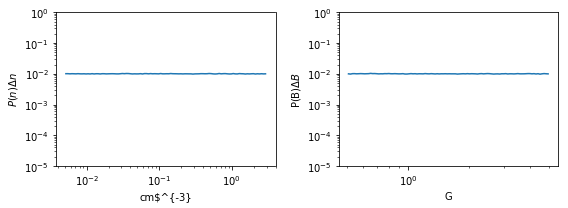

In [10]:
N = 10**6

fig, axs = plt.subplots( 1, 2, figsize=(8,3) )
n = Sample_n( N )
P, x = histogram(n, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"Prior(n)", ax=axs[0] )
axs[0].set_ylim(1e-5,1)
axs[0].set_ylabel("$P(n) \Delta n$")
axs[0].set_xlabel(r"cm$^{-3}")

B = Sample_B( N )
P, x = histogram(B, log=True, density=True, bins=100)
PlotLikelihood( x, P, density=False, label=r"Prior(B)", ax=axs[1] )
axs[1].set_ylim(1e-5,1)
axs[1].set_ylabel("P(B)$\Delta B$")
axs[1].set_xlabel(r"G")
#axs[1].set_xticks( [B_lo,B_hi], minor=True )

plt.tight_layout()
plt.show()

For the final likelihood function, we combine predictions for several $n_{\rm ISM}$ and $B_{\rm Host}$.

To save computation time, we probe an individual sample of $n_{\rm ISM}$ for each $B_{\rm Host}$ instead of a sample of radnom tuples.

In [55]:
N_n, N_B = 70, 15


def Combine_P_n( N=N_n, measure='DM', plot=False, ax=None, **kwargs ):
    if ax is None:
        fig, ax = plt.subplots()
    ns = Sample_n( N )
    f_ns = ns / ns[0]

    if measure == 'DM':
        P, x = Likelihood_DM( ns[0], **kwargs )
    elif measure == 'RM':
        P, x = Likelihood_RM( n=ns[0], **kwargs )  
        
    
    Pfs, xfs = [], []
    for f in f_ns:
        xfs.append( x*f )
        Pfs.append( P/f )
    if plot:
        for n, x, P in zip( ns, xfs, Pfs):
            PlotLikelihood( x, P, density=False, log=True, ax=ax, measure='RM', label='n = %f cm$^{-3}$}' % n)
        
    return AddLikelihoods( Pfs, xfs )

def Combine_P_n( N=N_n, measure='DM', plot=False, ax=None, **kwargs ):
    if ax is None and plot:
        fig, ax = plt.subplots()
    ns = Sample_n( N )
    ds = Sample_depth( N_depths )
    f_ns = ns / ns[0]

    (P, x), (P1, x1) = Likelihood_RMDM( DM_min=1e-1, RM_min=1e-1, depths=ds)
    if measure == 'RM':
        P, x = P, x
    elif measure == 'DM':
        P, x = P1, x1
    
    Pfs, xfs = [], []
    for f in f_ns:
        xfs.append( x*f )
        Pfs.append( P/f )
    if plot:
        for n, x, P in zip( ns, xfs, Pfs):
            PlotLikelihood( x, P, density=False, log=True, ax=ax, measure='RM', label='n = %f cm$^{-3}$}' % n)
        
    return AddLikelihoods( Pfs, xfs )


Here we compute the likelihood function for RM or DM and write it to file


100%|██████████| 1/1 [01:14<00:00, 74.13s/it]


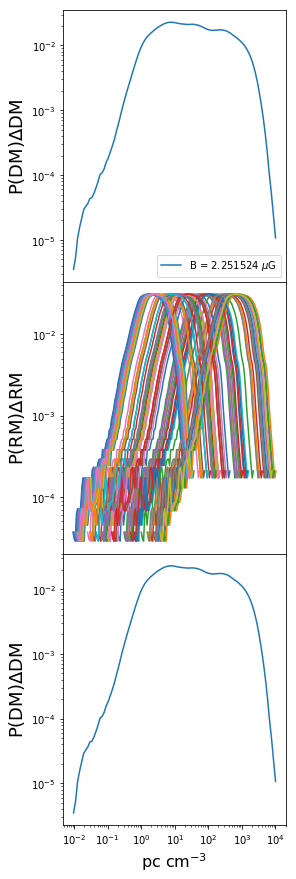

75.8 seconds


In [58]:
t0 = time()

measure='RM'
measure='DM'

Bs = Sample_B( N_B )
if measure == 'DM':
#    Bs = np.array([Bs[0]])
    Bs = np.array(Bs[:1])

fig, axs = plt.subplots(2+len(Bs), 1, sharex='all', figsize=(4,15))
fig.subplots_adjust( hspace=0 )#, wspace=0 )
    
Ps, xs = [], []
#for i_B, B in enumerate( Bs ):
for i_B in trange( Bs.size):
    B = Bs[i_B]
    P, x = Combine_P_n( measure=measure, N=N_n, plot=True, ax=axs[i_B+1], B=B )
    PlotLikelihood( x, P, density=False, log=True, ax=axs[0], measure=measure, label='B = %f $\mu$G' % B)
    Ps.append( P )
    xs.append( x )

axs[0].legend()
#axs[1].legend()

P, x = AddLikelihoods( Ps, xs )
PlotLikelihood( x, P, density=False, log=True, measure=measure, ax=axs[-1])
plt.show()

Write2h5( likelihood_file_galaxy, [P, x], [ KeyHost( 'Heesen11', 'dirty', measure+'/'+axis ) for axis in ['P','x']]   )


## delete all the temporary files
os.system( "rm -rf ../physics/FRB/IC10/Polsims/theta*" )

print '%.1f seconds' % ( time() - t0 )

In [35]:
print likelihood_file_galaxy, os.path.isfile(likelihood_file_galaxy)

data/FRB/DMRMlikelihood_galaxy.h5 True


In [32]:
root

''

DON'T USE THE FOLLOWING!

 do prediction for DM, 
 n_e = 0.05 cm^-3 = const, cylinder of 2 kpc radius, 700 pc height
 find distribution of column depths
 

In [14]:
h = 700. # pc
r = 2000. # pc
n_e = 0.05 # cm^-3


def Likelihood_DM( n=0.05, N_depths=1000, N_theta=1000 ):

    #depths = np.linspace( 0.05, 0.95, N_depths )           ## fixed equidistant depths
    #depths = np.random.rand( N_depths )              ## fixed random depths
    depths = np.random.rand( N_theta, N_depths )     ## random depths
    h_depths = np.random.rand( N_theta, N_depths )     ## random depths
    r_depths = np.random.rand( N_theta, N_depths )     ## random depths

    #thetas = np.arccos( np.linspace( 0, 1, N_theta ) )                ## fixed evenly distributed thetas
    #thetas = np.arccos( np.random.rand( N_theta ) )            ## fixed random thetas
    thetas = np.arccos( np.random.rand( N_theta, N_depths ) )  ## random thetas

    depths = depths.flatten()
    thetas = thetas.flatten()

    #th = np.array( [thetas]*N_depths ).transpose()
    #ds = np.array( [depths]*N_theta )
    #plt.scatter( thetas.flatten(), depths.flatten() )


#    d = lambda th: 2*h*np.cos(th) + 2*r*np.sin(th)
    d = lambda th, h_d, r_d: h_d*2*h*np.cos(th) + r_d*2*r*np.sin(th)

#    DMs = n * np.array([ d(th)*f for th, f in zip( thetas, depths) ])
    DMs = n * np.array([ d(th, h_d, r_d)*f for th, h_d, r_d, f in zip( thetas, h_depths, r_depths, depths) ])

    return histogram( DMs, log=True, bins=100, density=True, range=(1e-3,DMs.max()*1.13) )

#plt.plot( thetas, ds )



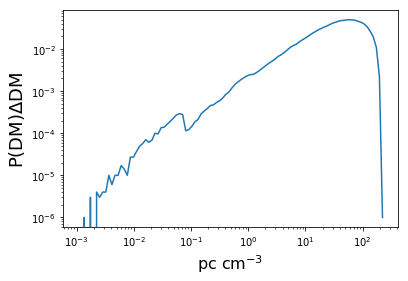

In [15]:
P, x = Likelihood_DM()
PlotLikelihood( x, P, measure='DM', density=False )


Here we finally compute the DM likelihood functino and write it to file

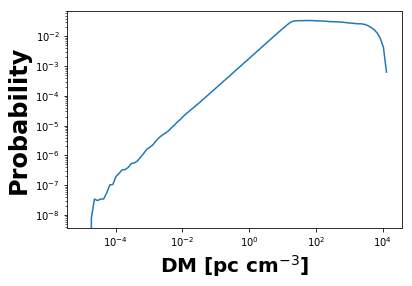

154.7 seconds


In [14]:
t0 = time()
P, x = Combine_P_n( measure='DM', N=3000, plot=True )
PlotLikelihood( x, P, density=False, log=True, measure='DM' )
plt.show()

Write2h5( likelihood_file_galaxy, [P, x], [ KeyHost( 'Heesen11', 'dirty', 'DM/'+axis ) for axis in ['P','x']]   )

print '%.1f seconds' % (time() - t0)

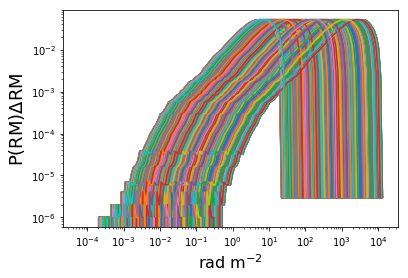

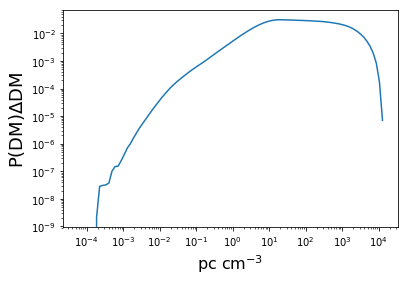

37.9 seconds


In [16]:
t0 = time()
P, x = Combine_P_n( measure='DM', N=3000, plot=True )
PlotLikelihood( x, P, density=False, log=True, measure='DM' )
plt.show()

Write2h5( likelihood_file_galaxy, [P, x], [ KeyHost( 'Heesen11', 'dirty', 'DM/'+v ) for v in ['P','x']]   )

print '%.1f seconds' % (time() - t0)